# IAB딥러닝 10월 25일
> 이미지자료분석 --> Transfer Learning, CAM(설명가능한 인공지능모형, XAI)

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김준형

# Import

In [1]:
import torch
import torchvision
from fastai.vision.all import *

In [39]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
# plt.plot 오류 발생 시 사용

In [56]:
import gc

gc.collect()
torch.cuda.empty_cache()

# Transfer Learning

In [2]:
path = untar_data(URLs.CIFAR)

In [3]:
path.ls()

(#3) [Path('C:/Users/USER/.fastai/data/cifar10/labels.txt'),Path('C:/Users/USER/.fastai/data/cifar10/test'),Path('C:/Users/USER/.fastai/data/cifar10/train')]

## 수제 네트워크

### (1) dls

In [4]:
dls = ImageDataLoaders.from_folder(path, train = 'train', valid = 'test')

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [5]:
_X, _y = dls.one_batch()
_X.shape, _y.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

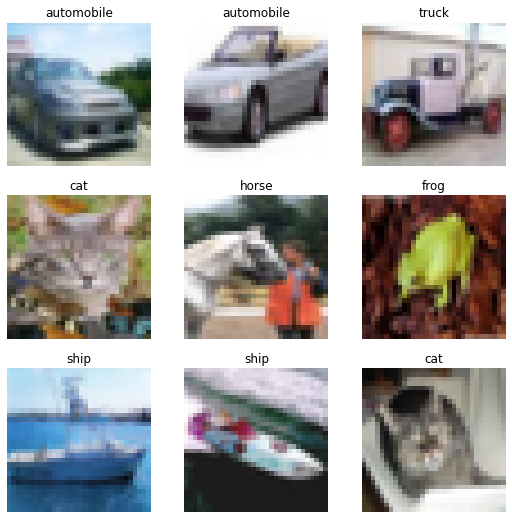

In [6]:
dls.show_batch()

### (2) lrnr

In [7]:
net1 = torch.nn.Sequential(torch.nn.Conv2d(3, 128, (5, 5)),
                          torch.nn.ReLU(),
                          torch.nn.MaxPool2d((2, 2)),
                          torch.nn.Flatten())

In [8]:
net1(_X.to("cpu")).shape

torch.Size([64, 25088])

In [9]:
net = torch.nn.Sequential(net1,
                         torch.nn.Linear(25088, 10))
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = Learner(dls, net, loss_fn, metrics = accuracy)

### (3) 학습

In [10]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.255423,1.237127,0.566300,00:50
1,1.107240,1.141914,0.598900,00:48
2,0.989954,1.069399,0.639700,00:48
3,0.920135,1.054571,0.640000,00:48
4,0.834212,1.025481,0.656600,00:48
5,0.810602,1.131336,0.621600,00:48
6,0.760466,1.064430,0.650700,00:48
7,0.665804,1.088443,0.653300,00:48
8,0.629648,1.087158,0.661800,00:48
9,0.583727,1.148374,0.647400,00:48


## 전이학습 (남이 만든 네트워크)

### (2) lrnr

In [11]:
net = torchvision.models.resnet18(weights=torchvision.models.resnet.ResNet18_Weights.IMAGENET1K_V1)
net

AttributeError: module 'torchvision.models.resnet' has no attribute 'ResNet18_Weights'

In [12]:
net.fc = torch.nn.Linear(in_features=512, out_features=10) 

In [13]:
loss_fn = torch.nn.CrossEntropyLoss() 
lrnr = Learner(dls,net,loss_fn,metrics=accuracy)

In [14]:
lrnr.fit(10) 

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x10 and 512x10)

In [16]:
path = untar_data(URLs.PETS) / 'images'

In [17]:
files = get_image_files(path)

In [18]:
def label_func(fname):
    if fname[0].isupper():
        return 'cat'
    else:
        return 'dog'

In [19]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms = Resize(512))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [20]:
lrnr = vision_learner(dls, resnet34, metrics = accuracy)

In [21]:
lrnr.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.158030,0.024365,0.991881,01:43


epoch,train_loss,valid_loss,accuracy,time
0,0.044585,0.028748,0.993234,02:05


In [22]:
lrnr.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

# CAM

`-` Class Activation Mapping(CAM)은 설명가능한 인공지능모형 (eXplainable Artificial Intelligence, XAI) 중 하나로 CNN의 판단근거를 시각화하는 기술

## Data Load

In [23]:
path = untar_data(URLs.PETS) / 'images'

In [24]:
path.ls()

(#7393) [Path('C:/Users/USER/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),Path('C:/Users/USER/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),Path('C:/Users/USER/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),Path('C:/Users/USER/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.mat'),Path('C:/Users/USER/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),Path('C:/Users/USER/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.mat'),Path('C:/Users/USER/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg'),Path('C:/Users/USER/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.mat'),Path('C:/Users/USER/.fastai/data/oxford-iiit-pet/images/Abyssinian_103.jpg'),Path('C:/Users/USER/.fastai/data/oxford-iiit-pet/images/Abyssinian_104.jpg')...]

In [25]:
files = get_image_files(path)

def label_func(fname):
    if fname[0].isupper():
        return 'cat'
    else:
        return 'dog'

## 구현 0단계 --> 예비학습

하나의 이미지 선택

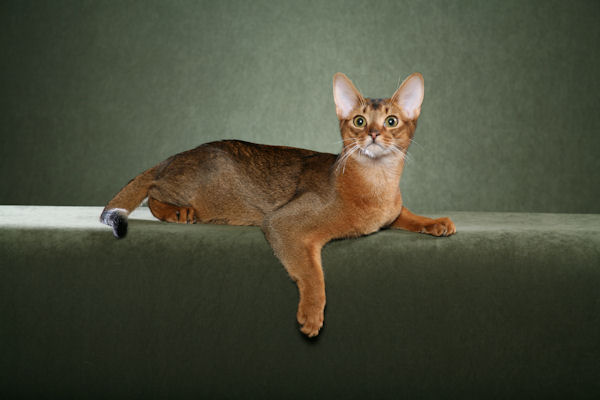

In [26]:
ximg = PILImage.create('C:/Users/USER/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg')
ximg

In [27]:
x = first(dls.test_dl([ximg]))[0]
x

TensorImage([[[[-1.1589, -1.1418, -1.1247,  ..., -0.9020, -0.9363, -0.9534],
          [-1.1589, -1.1418, -1.1247,  ..., -0.8849, -0.9192, -0.9363],
          [-1.1589, -1.1418, -1.1247,  ..., -0.8849, -0.9020, -0.9192],
          ...,
          [-1.8439, -1.8439, -1.8439,  ..., -1.7240, -1.7240, -1.7240],
          [-1.8439, -1.8439, -1.8439,  ..., -1.7240, -1.7240, -1.7240],
          [-1.8439, -1.8610, -1.8610,  ..., -1.7240, -1.7240, -1.7240]],

         [[-0.8627, -0.8452, -0.8277,  ..., -0.6001, -0.6352, -0.6527],
          [-0.8627, -0.8452, -0.8277,  ..., -0.5826, -0.6176, -0.6352],
          [-0.8627, -0.8452, -0.8277,  ..., -0.5826, -0.6001, -0.6176],
          ...,
          [-1.6331, -1.6331, -1.6331,  ..., -1.5280, -1.5280, -1.5280],
          [-1.6331, -1.6331, -1.6331,  ..., -1.5280, -1.5280, -1.5280],
          [-1.6331, -1.6506, -1.6506,  ..., -1.5280, -1.5280, -1.5280]],

         [[-0.9330, -0.9156, -0.8981,  ..., -0.6715, -0.7064, -0.7238],
          [-0.9330, -0.91

AP layer

In [28]:
ap = torch.nn.AdaptiveAvgPool2d(output_size = 1)

In [29]:
X = torch.arange(48).reshape(1, 3, 4, 4) * 1.0
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[16., 17., 18., 19.],
          [20., 21., 22., 23.],
          [24., 25., 26., 27.],
          [28., 29., 30., 31.]],

         [[32., 33., 34., 35.],
          [36., 37., 38., 39.],
          [40., 41., 42., 43.],
          [44., 45., 46., 47.]]]])

In [30]:
ap(X)

tensor([[[[ 7.5000]],

         [[23.5000]],

         [[39.5000]]]])

In [31]:
X[0, 0, ...].mean(), X[0, 1, ...].mean(), X[0, 2, ...].mean()

(tensor(7.5000), tensor(23.5000), tensor(39.5000))

torch.einsum

(예시 1)

In [32]:
tsr = torch.arange(12).reshape(4, 3)
tsr

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]])

In [33]:
torch.einsum('ij->ji', tsr)

tensor([[ 0,  3,  6,  9],
        [ 1,  4,  7, 10],
        [ 2,  5,  8, 11]])

(예시 2)

In [34]:
tsr1 = torch.arange(12).reshape(4, 3).float()
tsr2 = torch.arange(15).reshape(3, 5).float()

In [35]:
tsr1 @ tsr2

tensor([[ 25.,  28.,  31.,  34.,  37.],
        [ 70.,  82.,  94., 106., 118.],
        [115., 136., 157., 178., 199.],
        [160., 190., 220., 250., 280.]])

In [36]:
torch.einsum('ij, jk -> ik', tsr1, tsr2)

tensor([[ 25.,  28.,  31.,  34.,  37.],
        [ 70.,  82.,  94., 106., 118.],
        [115., 136., 157., 178., 199.],
        [160., 190., 220., 250., 280.]])

(예시 3)

In [37]:
x.to("cpu").shape

torch.Size([1, 3, 512, 512])

In [38]:
torch.einsum('ocij -> ijc', x.to("cpu")).shape

torch.Size([512, 512, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


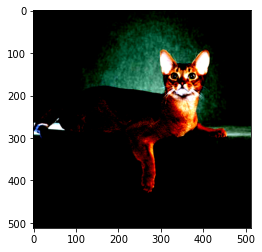

In [40]:
plt.imshow(torch.einsum('ocij -> ijc', x.to('cpu')))

## 구현 1단계 --> 이미지분류 잘하는 네트워크 선택

In [41]:
lrnr = vision_learner(dls, resnet34, metrics = accuracy)

In [42]:
lrnr.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.169289,0.034462,0.989175,01:34


epoch,train_loss,valid_loss,accuracy,time
0,0.050309,0.018232,0.995940,02:10


## 구현 2단계 --> 네트워크의 끝 부분 수정

In [43]:
net1 = lrnr.model[0]
net2 = lrnr.model[1]

In [44]:
net2

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [45]:
_X, _y = dls.one_batch()

In [46]:
net1.to('cpu')
net2.to('cpu')
_X = _X.to('cpu')

In [47]:
print(net1(_X).shape)
print(net2[0](net1(_X)).shape)
print(net2[1](net2[0](net1(_X))).shape)
print(net2[2](net2[1](net2[0](net1(_X)))).shape)

torch.Size([64, 512, 16, 16])
torch.Size([64, 1024, 1, 1])
torch.Size([64, 1024])
torch.Size([64, 1024])


`-` net2를 아래와 같이 수정하고 재학습

In [48]:
net2 = torch.nn.Sequential(torch.nn.AdaptiveAvgPool2d(output_size = 1),
                          torch.nn.Flatten(),
                          torch.nn.Linear(512, 2, bias = False))

In [49]:
net = torch.nn.Sequential(net1, net2)

In [50]:
lrnr2 = Learner(dls, net, metrics = accuracy)

In [51]:
lrnr2.loss_func, lrnr.loss_func

(FlattenedLoss of CrossEntropyLoss(), FlattenedLoss of CrossEntropyLoss())

In [57]:
lrnr2.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 12.00 GiB total capacity; 10.81 GiB already allocated; 0 bytes free; 11.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## 구현 3단계 --> 수정된 net2에서 Linear와 AP의 순서를 바꿈

`-` 1개의 observation을 고정하였을 경우 출력과정 상상

In [58]:
ximg = PILImage.create('C:/Users/USER/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg')
x = first(dls.test_dl([ximg]))[0]

In [59]:
net2

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [60]:
print(net1(x).shape)
print(net2[0](net1(x)).shape)
print(net2[1](net2[0](net1(x))).shape)
print(net2[2](net2[1](net2[0](net1(x)))).shape)

torch.Size([1, 512, 16, 16])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512])
torch.Size([1, 2])


`-` 최종결과 확인

In [61]:
net(x)

TensorImage([[0.3050, 0.9786]], device='cuda:0', grad_fn=<AliasBackward0>)

In [62]:
dls.vocab

['cat', 'dog']

net(x)에서 뒤쪽의 값이 클수록 'dog'를 의미한다.

In [64]:
_x = torch.tensor([1, 2, 3.14, 4]).reshape(4, 1)
_x

tensor([[1.0000],
        [2.0000],
        [3.1400],
        [4.0000]])

In [65]:
_l1 = torch.nn.Linear(1, 1, bias = False)
_l1(_x).mean()

tensor(-0.0184, grad_fn=<MeanBackward0>)

In [66]:
_l1(_x.mean().reshape(1, 1))

tensor([[-0.0184]], grad_fn=<MmBackward0>)

`-` https://guebin.github.io/DL2022/2022/10/25/(8%EC%A3%BC%EC%B0%A8)-10%EC%9B%9425%EC%9D%BC.html

## 구현 4단계 --> CAM 시각화

`-` https://guebin.github.io/DL2022/2022/10/25/(8%EC%A3%BC%EC%B0%A8)-10%EC%9B%9425%EC%9D%BC.html

`-` IAB 딥러닝 수업 자료를 기반으로 공부한 내용입니다.